### Импорты

In [467]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product
from tqdm import tqdm_notebook

%matplotlib inline

In [468]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Выбрала для анализа временной ряд - данные об осадках 

### Данные

In [469]:
df = pd.read_csv('C:\\Users\\vrkry\\OneDrive\\Рабочий стол\\rainfall.csv', index_col=['date'], parse_dates=['date'])
df

,mean_rainfall
date,
1990-01-01,1.613
1990-01-11,1.557
1990-01-21,2.219
1990-02-01,4.788
1990-02-11,6.510
...,...
2019-11-11,6.737
2019-11-21,5.216
2019-12-01,2.022


In [470]:
df = df.resample('M').mean().dropna()
df

,mean_rainfall
date,
1990-01-31,1.796333
1990-02-28,5.270333
1990-03-31,9.169667
1990-04-30,16.180333
1990-05-31,78.126333
...,...
2019-08-31,174.259000
2019-09-30,83.920000
2019-10-31,44.260333


### Визуализация ряда и предположения о его компонентах (тренд, сезонность) и стационарности на основе внешнего вида

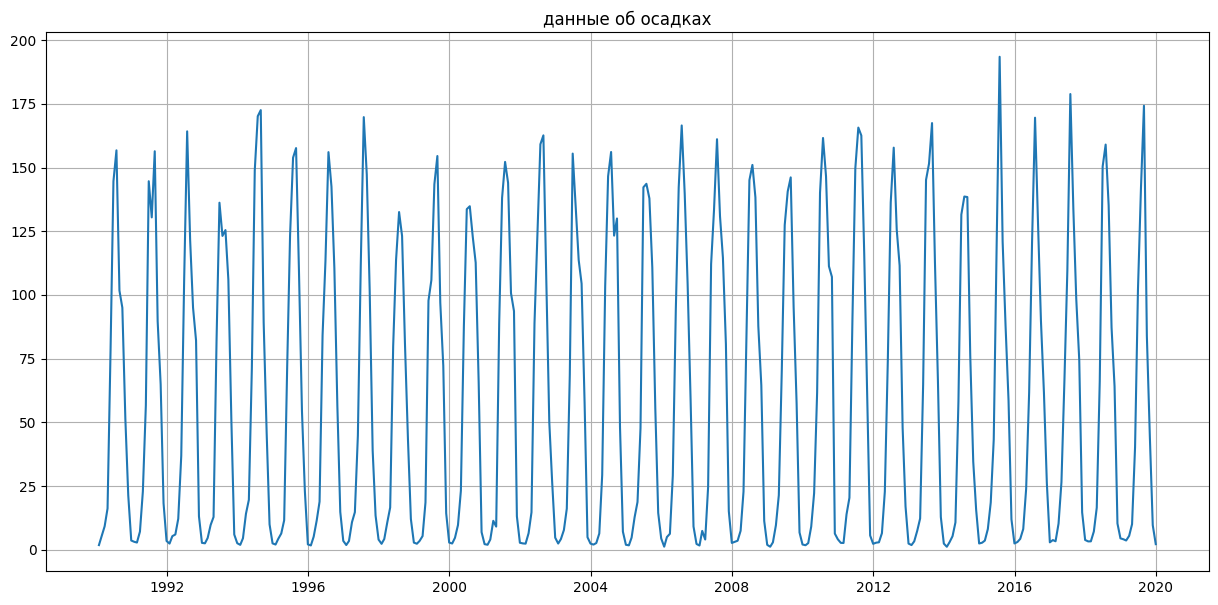

In [471]:
plt.figure(figsize=(15, 7))
plt.plot(df.mean_rainfall)
plt.title('данные об осадках')
plt.grid(True)
plt.show()

Наблюдается сезонность (рост осадков в начале каждого года, спад к концу), ряд не стационарен, тренд не выявлен

### train/test split

In [472]:
def train_test_split(df, test_size):

    test_index = int(len(df)*(1-test_size))

    df_train = df.iloc[:test_index]
    df_test = df.iloc[test_index:]

    return df_train, df_test


df_train, df_test = train_test_split(df, test_size=0.3)

### Бейзлайн в виде скользящего среднего

In [473]:
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(df_train, 3)

74.88077777777778

In [474]:
df_test.head(1)

,mean_rainfall
date,
2010-12-31,4.079667


### Визуализация скользящего среднего

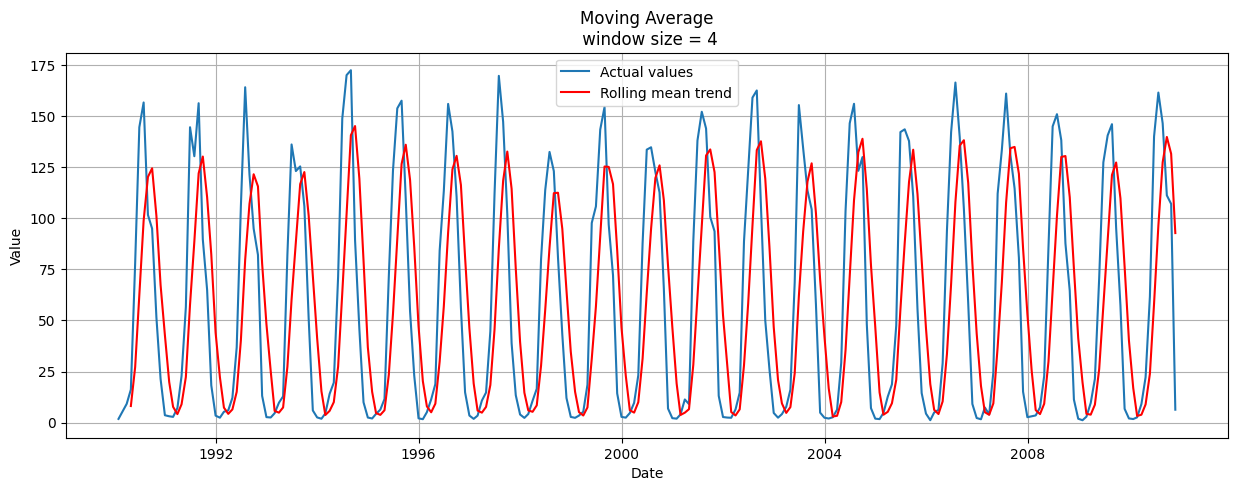

In [475]:
def plot_moving_average(series, window):
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15, 5))
    plt.plot(series.index, series, label='Actual values')
    plt.plot(rolling_mean.index, rolling_mean, 'r', label='Rolling mean trend')
    plt.title('Moving Average\n window size = {}'.format(window))
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_moving_average(df_train, 4)

### Для замеров качества работы Бейзлайн была рассчитана MAE 

In [476]:
mean_absolute_error([moving_average(df_train, 4)], df_test.head(1))


88.71700000000001

### Статистическая модель

### Тест Дики-Фуллера 

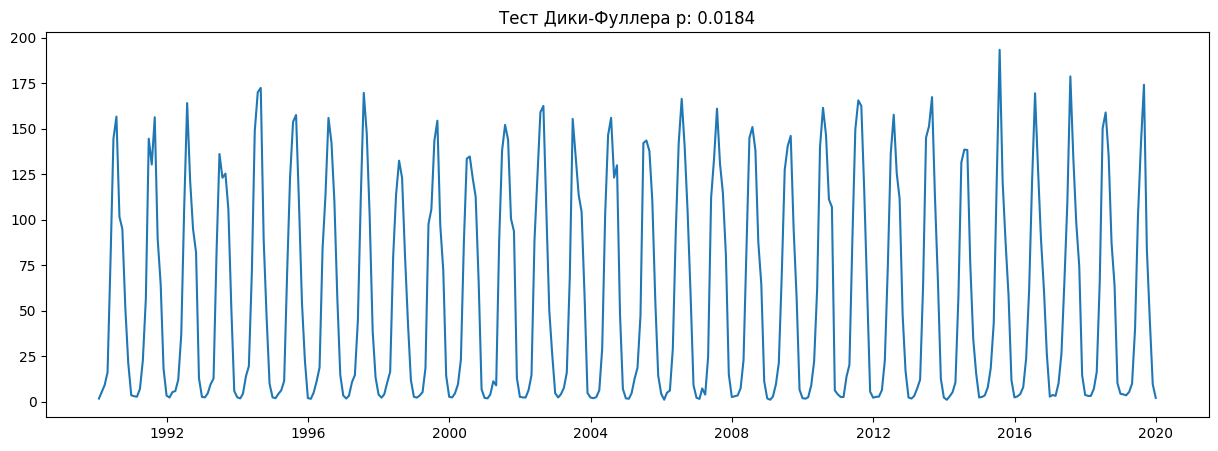

In [477]:
plt.figure(figsize=(15, 5))
plt.plot(df)
plt.title("Тест Дики-Фуллера p: {}".format(round(sm.tsa.stattools.adfuller(df_train)[1], 4)))
plt.show()

Значение p - маленькое. Данный тест указывает на стационарность ряда, однако не учитывает сезонность

### Построение графиков ACF/PACF 

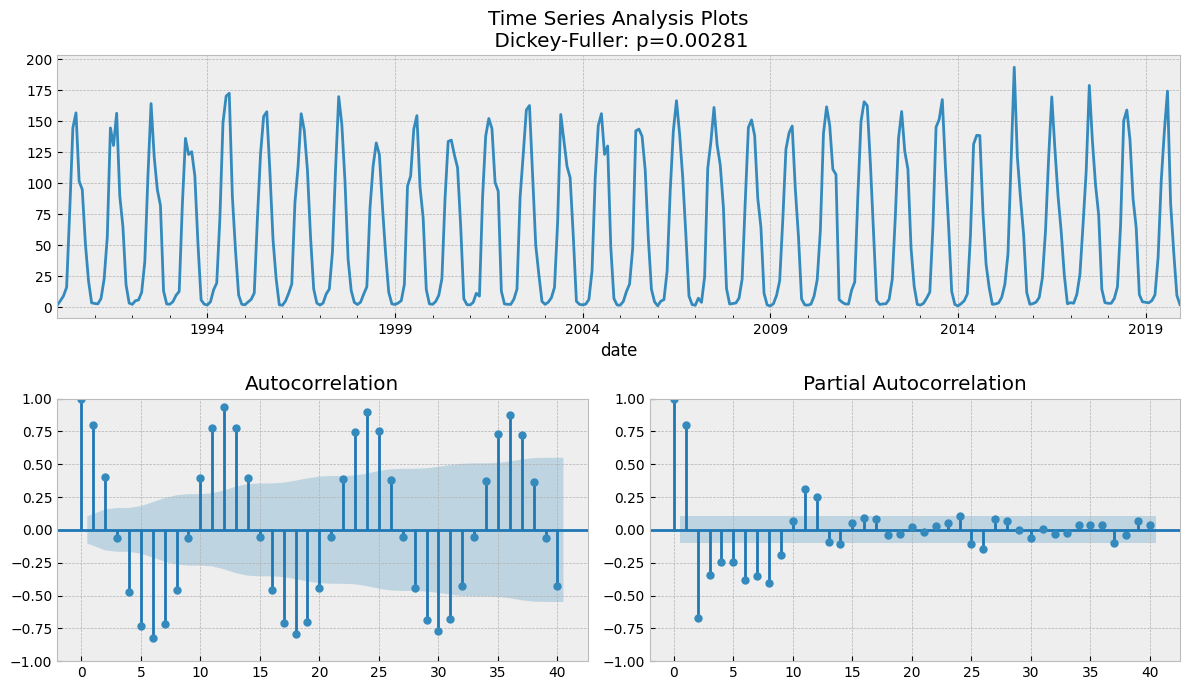

In [478]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

tsplot(df.mean_rainfall, lags=40)

По данным графика Autocorrelation - продолжительность сезонности 12 лагов, то есть 1 год


### Cезонное дифференцирование

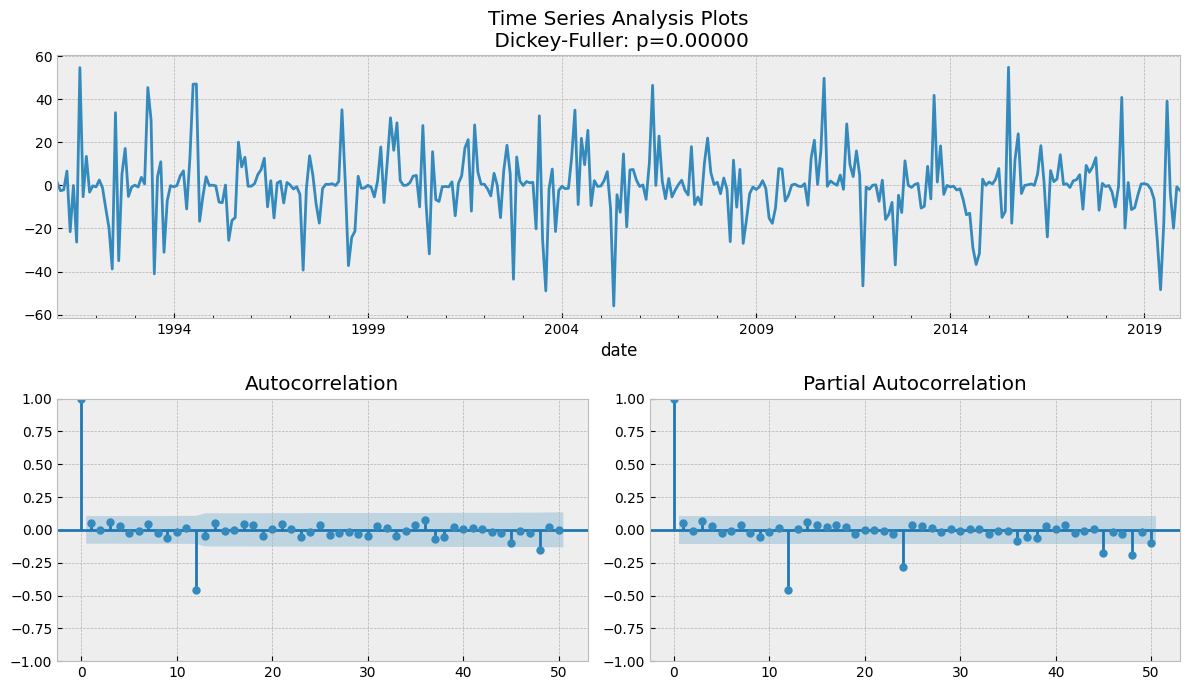

In [479]:
df_diff = df.mean_rainfall - df.mean_rainfall.shift(12)
tsplot(df_diff[12:], lags=50)

Тест указывает на стационарность ряда

### Обучение модели SARIMA для прогнозирования значений ряда подбором оптимальных параметров

In [480]:
def optimizeSARIMA(parameters_list, d, D, s):
    results = []
    best_aic = float("inf")
    
    for param in parameters_list:
        try:
            model = sm.tsa.statespace.SARIMAX(df.mean_rainfall, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

#значения были подобраны, исходя из ACF и PACF
ps = range(2, 4)
qs = range(2, 4)
Ps = range(0, 2)
Qs = range(2, 3)


parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

In [481]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

CPU times: total: 9.95 s
Wall time: 39.7 s


In [482]:
result_table.head()

,parameters,aic
0,"(3, 3, 1, 2)",2744.640959
1,"(3, 3, 0, 2)",2744.664410
2,"(3, 2, 1, 2)",2745.338800
3,"(2, 3, 1, 2)",2746.617793
4,"(2, 2, 1, 2)",2749.568035


In [483]:
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(df_train, order=(p, d, q),
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                           mean_rainfall   No. Observations:                  251
Model:             SARIMAX(3, 0, 3)x(1, 1, [1, 2], 12)   Log Likelihood                -939.369
Date:                                 Mon, 04 Mar 2024   AIC                           1898.738
Time:                                         19:22:40   BIC                           1933.503
Sample:                                     01-31-1990   HQIC                          1912.748
                                          - 11-30-2010                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4970      0.954      0.521      0.602      -1.372       2

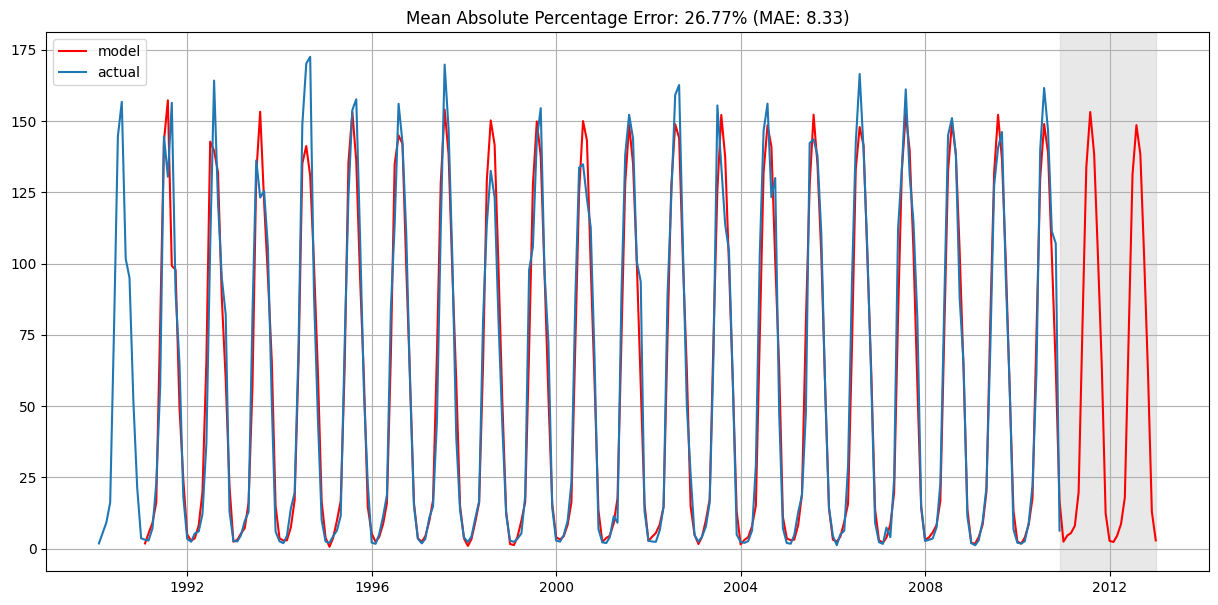

In [484]:
def plotSARIMA(series, model, n_steps):

    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    data['arima_model'][:s+d] = np.NaN

    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model._append(forecast)
    error1 = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    error2 = mean_absolute_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title(f"Mean Absolute Percentage Error: {round(error1, 2)}% (MAE: {round(error2, 2)})")
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True)

plotSARIMA(df_train, best_model, 24)

Результаты по сравнению в Бейзлайн улучшились: Mean Absolute Percentage Error = 26.7%, MAE = 8.33

### Классическая модель

In [485]:
data = pd.DataFrame(df.mean_rainfall.copy())
data.columns = ["y"]

In [486]:
for i in range(1, 37):
    data["lag_{}".format(i)] = data.y.shift(i)

### Создание признаков дня и месяца

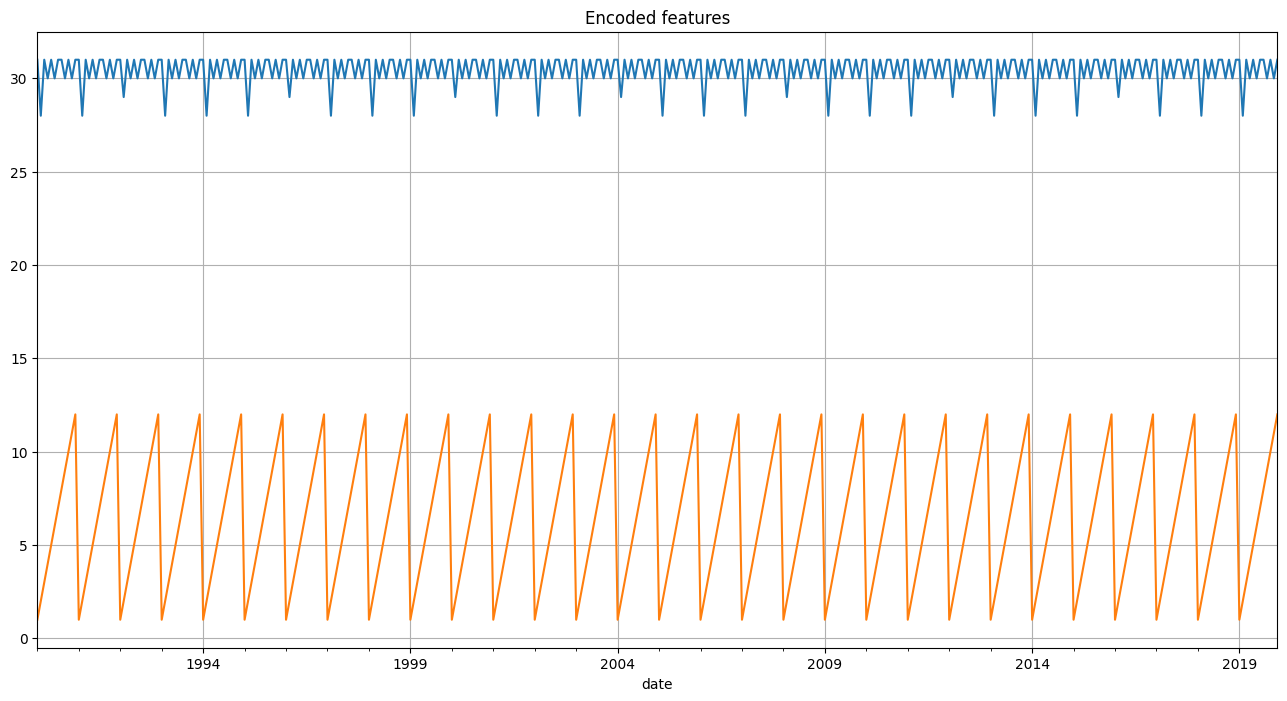

In [487]:
data['day'] = data.index.day
data['month'] = data.index.month
plt.figure(figsize=(16, 8))
plt.title("Encoded features")
data.day.plot()
data.month.plot()
#data.year.plot()
plt.grid(True);

### Обучение модели

### test/train split

In [488]:
def timeseries_train_test_split(X, y, test_size):

    test_index = int(len(X)*(1-test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

In [489]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [490]:
def plotModelResults(model, X_train=X_train, X_test=X_test):

    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

In [491]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=6, random_state=42)
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, random_state=42)

### Визуализация полученных результатов

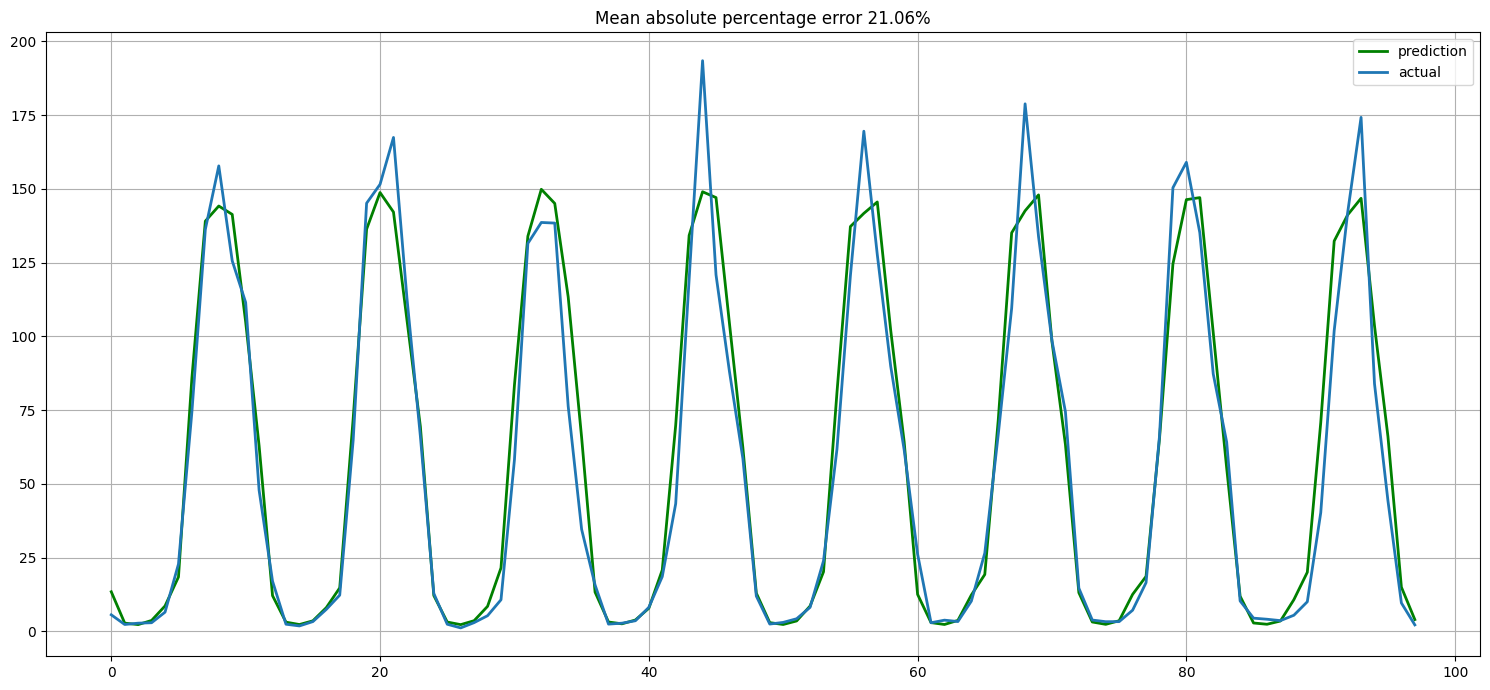

In [492]:
plotModelResults(regr, X_train=X_train, X_test=X_test)

MAE равна 21.06% - это меньше, чем результат SARIMA

### Интерпретация

### Permutation importance

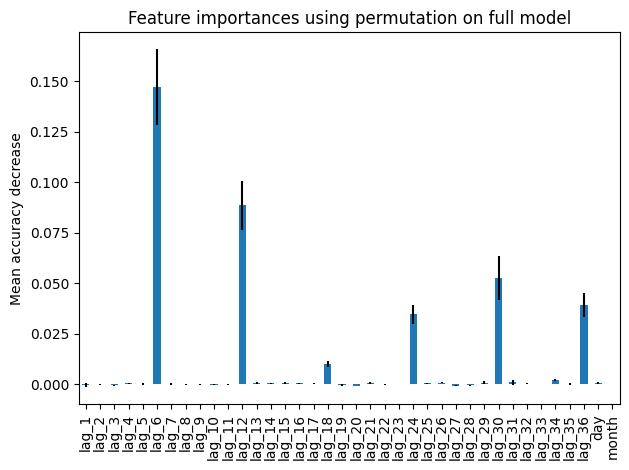

In [493]:
from sklearn.inspection import permutation_importance

importances = permutation_importance(regr, X_test, y_test, n_repeats=10, random_state=2023, n_jobs=2)
forest_importances = pd.Series(importances.importances_mean, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=importances.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

### Lime

In [494]:
from lime import lime_tabular


explainer = lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['rings'],
    verbose=True,
    mode='regression',
)
i = 33
exp = explainer.explain_instance(X_test.iloc[i].values, regr.predict, num_features=5)

Intercept 40.70457788092448
Prediction_local [126.29880338]
Right: 145.07163060270784


In [495]:
exp.show_in_notebook(show_table=True)

In [496]:
exp.as_list()

[('lag_6 <= 4.99', 28.667403104194477),
 ('lag_12 > 112.52', 20.0754522441564),
 ('lag_30 <= 5.14', 13.065764145171057),
 ('lag_36 > 112.01', 12.077296404256955),
 ('lag_24 > 112.52', 11.70830960378698)]

### SHAP (локальная)

In [497]:
import shap

explainer = shap.TreeExplainer(regr)

In [498]:
choosen_instance = X_test.iloc[[33]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

In [499]:
choosen_instance = X_test.iloc[[27]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

### SHAP (глобальная)

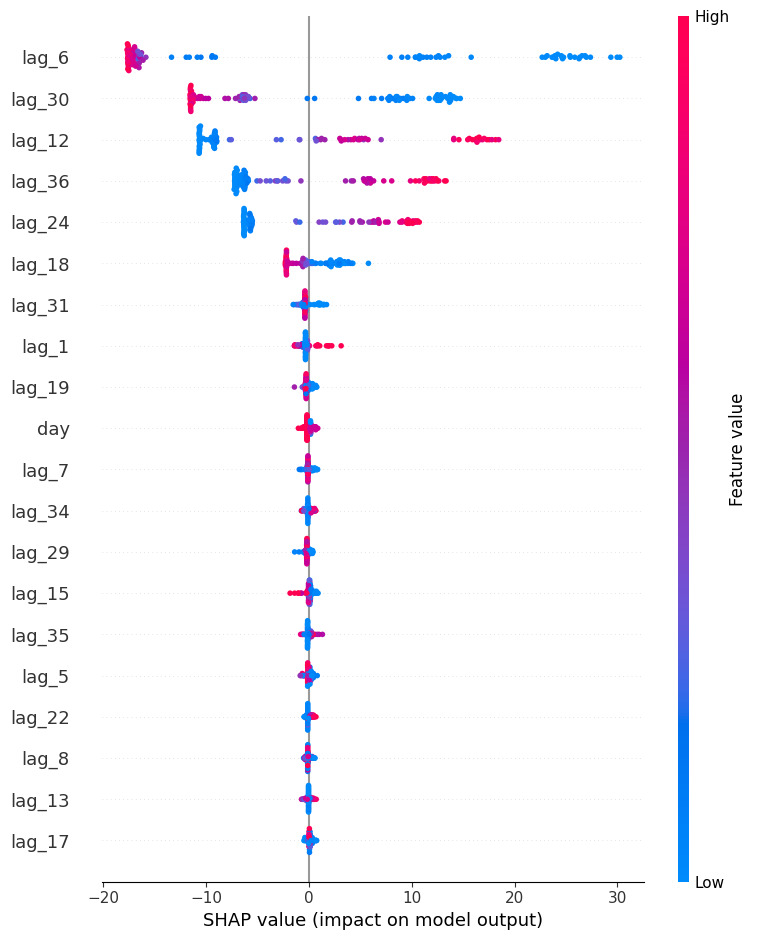

In [500]:
shap_values = explainer.shap_values(X_train.iloc[:100])
shap.summary_plot(shap_values, X_train.iloc[:100])

Можно сделать вывод, что оптимальными лагами для анализа являются значения, являющиеся делителями значения периода (12 лагов) или кратны этому значению